In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
import pandas as pd
from global_model_periodic_energy import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')


In [ ]:
def compute_polygon_area_and_perimeter(polygon):
    polygon = np.array(polygon)
    x = polygon[:, 0]
    y = polygon[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    perimeter = np.sum(np.linalg.norm(np.roll(polygon, -1, axis=0) - polygon, axis=1))
    return area, perimeter

def vornoi_area_and_perimeter(vor,target_indices):
    areas = []
    perimeters = []

    for idx in target_indices:
        region_index = vor.point_region[idx]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            areas.append(1e-10)
            perimeters.append(1e-10)
            continue
        polygon = [vor.vertices[i] for i in region]
        area, perimeter = compute_polygon_area_and_perimeter(polygon)
        areas.append(area)
        perimeters.append(perimeter)          
    return areas,perimeters

In [4]:
def voronoi_loss(output,target_indices,accelerations,target_areas= 0.4,masse = 0.1, dt = 0.05,perimeter_target = 2.4):
    areas = []
    perimeters = []
    vor = Voronoi(output.cpu().detach().numpy())
    area,perimeter = vornoi_area_and_perimeter(vor,target_indices)
    areas.append(area)
    perimeters.append(perimeter)
    areas_tensor = torch.tensor(np.array(areas), dtype=torch.float32).to(device)
    perimeters_tensor = torch.tensor(np.array(perimeters),dtype=torch.float32).to(device)
    # areas_tensor = torch.stack(areas)
    # perimeters_tensor = torch.stack(perimeters)
    physics_loss = 0.02*(target_areas - areas_tensor)**2 + 0.005*(perimeters_tensor-perimeter_target)**2#+1e-5*(target_areas/(areas_tensor))**2
    # kinetic_loss = torch.sum((0.5*masse*dt**2)*(accelerations/(dt**2))**2,dim=-1)
    # print(physics_loss,kinetic_loss)
    return (physics_loss).squeeze(0)#+kinetic_loss

In [5]:
def loss_complete(energy, target):
    mse_loss = torch.nn.functional.mse_loss(energy, target)
    return mse_loss

In [ ]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step,n_cells, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(1,11):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data).to(device) 
                    clean_positions.append(pos)

            for t in range(2, len(clean_positions)):
                input_seq = clean_positions[t-2:t+1] 
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2 * x_t1 + x_t2
                energy = voronoi_loss(x_t,np.arange(n_cells),acc[:n_cells])
                def noisy(x): 
                    x= x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x
                    return x
                    

                input_seq_noisy = torch.stack([noisy(x_t)]) 
                self.samples.append((input_seq_noisy, energy))
        random_data_path = "/home/jeanlienhard/Documents/Cell_GNN/Data/random_data/random_positions_"
        for i in range(1,5):
            csvpath = random_data_path + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data).to(device)
                    clean_positions.append(pos)

            for t in range(2, len(clean_positions)):
                input_seq = clean_positions[t-2:t+1]
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2 * x_t1 + x_t2
                energy = voronoi_loss(x_t,np.arange(n_cells),acc[:n_cells])
                def noisy(x): 
                    x= x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x
                    return x

                input_seq_noisy = torch.stack([noisy(x_t)])
                self.samples.append((input_seq_noisy, energy))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [8]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float).to(device)
    energy = model(x,n_cells)
    return energy

In [ ]:
def avg_test(model,device,csv_file,n_cells):
    model.eval()
    loss = 0
    target_indices = np.arange(n_cells)
    csvpath = csv_file + str(57) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy = generate_next_positions(model, device, [positions],n_cells)
        loss_actu=torch.nn.functional.mse_loss(energy,1e4*voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),target_indices,None)).item()
        loss+=loss_actu
    return loss/200
        

In [ ]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = StepLR(optimizer, 25,gamma = 0.8)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=200,n_cells = n_cells, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)
            acc = acc.to(device).squeeze(0)
            acc =acc[:n_cells]
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0)
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                energy = model(input_traj,n_cells)
                loss = loss_fn(energy, acc*1e4)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1
        scheduler.step()
        avg_loss = total_loss / total_batches if total_batches > 0 else 0

        if epoch % 1 == 0:
            for param_group in optimizer.param_groups:
                print(f"Current learning rate: {param_group['lr']}")
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(acc*1e4,energy)
            path_prefix = "/home/jeanlienhard/Documents/Cell_GNN/GNN for energy/Training/Energy_with_perimeter_3layer/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [11]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e0, 1e0]).to(device)}
}

In [ ]:

model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device,n_cells = 10)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_",
    loss_fn=loss_complete,
    epochs= 301,
    lr=1e-4,
    batch_size=1,
    seq_len=30,
    noise_std=0.0,
    device='cuda'
)


Loading dataset...
Dataset loaded in 4.65 seconds


  0%|          | 0/301 [00:00<?, ?it/s]W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0] Graph break from `Tensor.item()`, consider setting:
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0]     torch._dynamo.config.capture_scalar_outputs = True
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0] or:
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0] to include these operations in the captured graph.
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0] 
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0] Graph break: from user code at:
W0716 10:48:42.007000 1979161 torch/_dynamo/variables/tensor.py:913] [0/0]   File "/home/jeanlienhard/Documents/Cell_GNN/GNN for energy/global_model_periodic_energy.py", line 30, in forward
W0716 

Current learning rate: 0.0001
Epoch 1/301, Avg Loss: 150.148537




KeyboardInterrupt



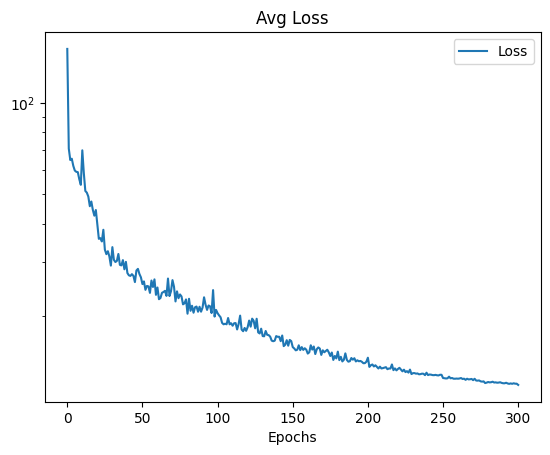

In [ ]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

[38.234817156791685, 35.70769170761108, 36.032739305496214, 39.087794847488404, 33.40233896136284, 31.557986311912536, 30.570437248945236, 32.193853807449344, 43.83499525785446, 34.132933267354964, 39.709502916336056, 32.82355745911598, 30.399558117389677, 32.34378586053848, 29.74181878209114, 30.60207181096077, 35.859693217277524, 27.787740198373793, 25.411779190301896, 27.314273204803467, 30.31074989914894, 23.62040289402008, 28.607112770080565, 23.491449538469315, 24.15165158867836, 23.896834123134614, 28.271685819625855, 21.349039641618727, 21.22661900639534, 20.31855927467346, 24.622420345544814, 21.443346054553984, 18.151570715904235, 21.134629735350607, 20.120897542238236, 20.106517832279206, 19.608764595985413, 20.508518068790437, 20.302777274250985, 20.488439544439316, 20.57788587808609, 24.37531298995018, 23.476319153308868, 16.402954313755036, 19.862266969680785, 21.37393578708172, 19.863606365919114, 23.885638074874876, 30.914296184778213, 23.83856160104275, 18.580153570175

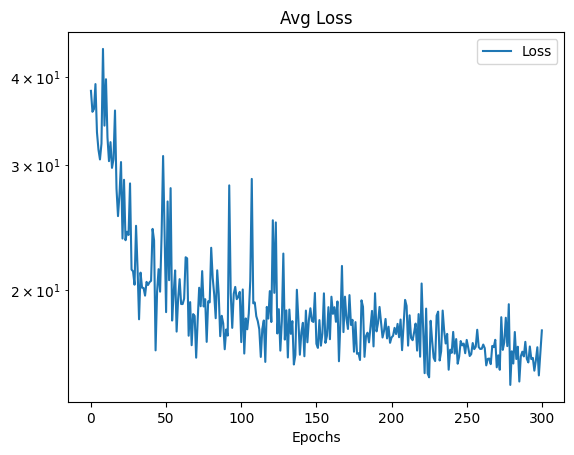

In [ ]:
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

In [ ]:
def comparison_total_energy(model,n_cells, device, input_csv):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    energy_true = []
    energy_computed = []
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions],n_cells)
        energy = voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),np.arange(n_cells),None)
        energy_true.append(torch.sum(energy).item()*1e4)
        energy_computed.append(torch.sum(energy_predicted).item()) 
    return energy_true,energy_computed

In [ ]:
energy_true,energy_computed = comparison_total_energy(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_57.csv")

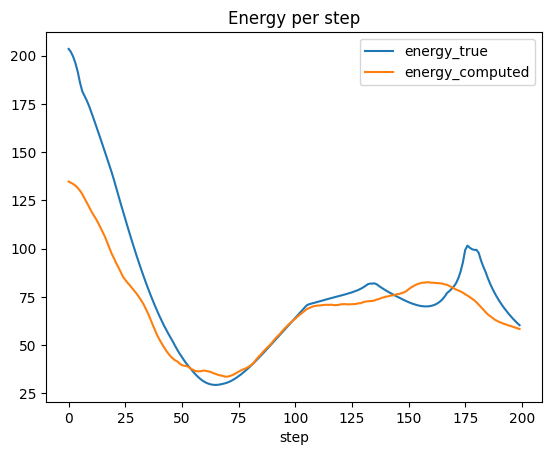

In [ ]:
plt.plot(energy_true, label='energy_true')
plt.plot(energy_computed, label='energy_computed')
# plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Energy per step')
plt.show()

In [ ]:
def comparison_one_cell_energy(model,n_cells, device, input_csv,cell_id):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    energy_true = []
    energy_computed = []
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions],n_cells)
        energy = voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),np.arange(n_cells),None)
        energy_true.append((energy[cell_id]).item()*1e4)
        energy_computed.append((energy_predicted[cell_id]).item()) 
    return energy_true,energy_computed

In [ ]:
energy_true_one,energy_computed_one = comparison_one_cell_energy(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_57.csv",0)

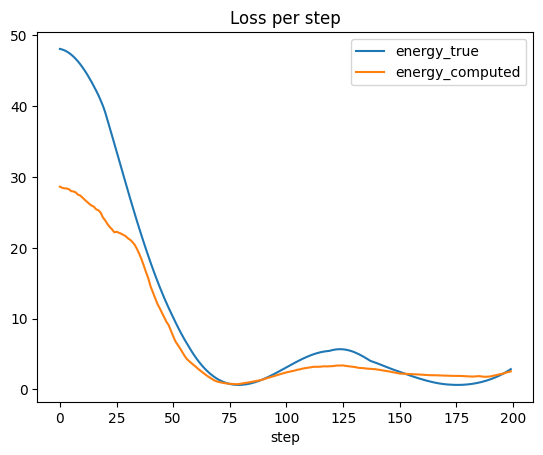

In [ ]:
plt.plot(energy_true_one, label='energy_true')
plt.plot(energy_computed_one, label='energy_computed')
# plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [ ]:
def comparison_many_cells_energy(model, n_cells, device, input_csv, cell_ids):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    
    energy_true_all = {cell_id: [] for cell_id in cell_ids}
    energy_computed_all = {cell_id: [] for cell_id in cell_ids}
    
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions], n_cells)
        energy = voronoi_loss(torch.tensor(positions, dtype=torch.float32).to(device), np.arange(n_cells), None)
        
        for cell_id in cell_ids:
            energy_true_all[cell_id].append((energy[cell_id]).item() * 1e4)
            energy_computed_all[cell_id].append((energy_predicted[cell_id]).item())
    
    return energy_true_all, energy_computed_all


In [ ]:
cell_ids = list(range(10))
energy_true_all, energy_computed_all = comparison_many_cells_energy(model, 10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_42.csv", cell_ids)


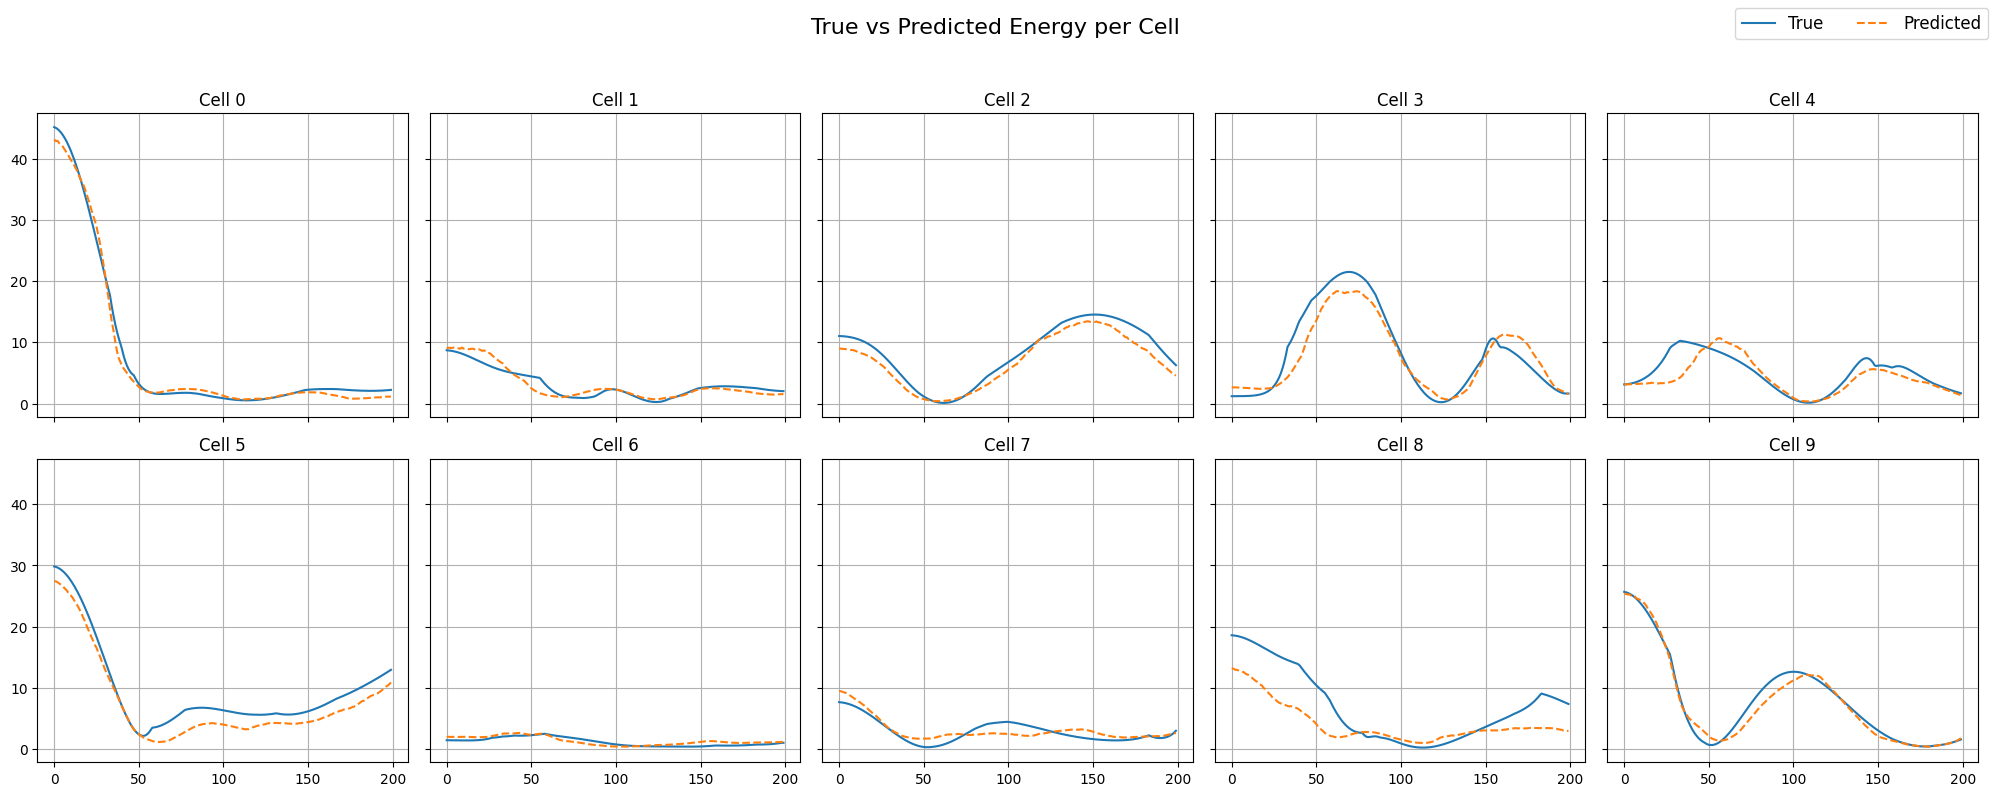

In [ ]:
cell_ids = list(range(10))
n_cols = 5
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

for i, cell_id in enumerate(cell_ids):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    
    ax.plot(energy_true_all[cell_id], label="True", linestyle='-')
    ax.plot(energy_computed_all[cell_id], label="Predicted", linestyle='--')
    ax.set_title(f"Cell {cell_id}")
    ax.grid(True)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, fontsize=12)

fig.suptitle("True vs Predicted Energy per Cell", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()